In [45]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TrainingArguments, Trainer, BertForSequenceClassification, get_linear_schedule_with_warmup
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import TensorDataset
import torchmetrics

In [23]:
# Load the dataset
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/AlexanderHolmes0/true-fake-news/" + splits["train"])

# Combine train and test datasets if needed (optional step)
df_test = pd.read_parquet("hf://datasets/AlexanderHolmes0/true-fake-news/" + splits["test"])
df = pd.concat([df, df_test], axis=0)

# Step 1: Cleaning the Data
# Drop rows with missing text
df = df.dropna(subset=['text'])

# Convert all entries to strings to avoid issues during tokenization
df['text'] = df['text'].astype(str)

# Step 2: Text Cleaning (if needed)
# Removing unwanted characters, e.g., URLs, special characters, etc.


def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove special characters except punctuation
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Step 3: Swap labels (Fake -> 0, Real -> 1)
df['label'] = df['label'].map({0: 1, 1: 0})


In [27]:
from sklearn.utils import resample
# Step 4: Data Augmentation and Resampling
# Balance the dataset to handle class imbalance
majority = df[df.label == 1]
minority = df[df.label == 0]

# Upsample minority class
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine majority and upsampled minority
df = pd.concat([majority, minority_upsampled])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
from sklearn.model_selection import train_test_split
# Step 5: Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Step 6: Tokenization using FinBERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

def tokenize_data(df, tokenizer, max_length=256):
    texts = list(df['cleaned_text'])
    labels = list(df['label'])
    encoded_inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
    )
    return encoded_inputs, torch.tensor(labels)

In [71]:
# Custom Dataset Class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [75]:
# Tokenize train and validation sets

train_inputs, train_labels = tokenize_data(train_df, tokenizer)
val_inputs, val_labels = tokenize_data(val_df, tokenizer)

# Prepare datasets for Trainer
from torch.utils.data import TensorDataset

# Prepare datasets for Trainer
train_dataset = NewsDataset(train_inputs, train_labels)
val_dataset = NewsDataset(val_inputs, val_labels)


In [57]:
from transformers import TrainingArguments,get_linear_schedule_with_warmup

# Define training arguments with learning rate scheduler
training_args = TrainingArguments(
    output_dir='./results',  # Output directory for model checkpoints
    num_train_epochs=5,  # Increased epochs to ensure better convergence
    per_device_train_batch_size=16,  # Adjusted batch size for better utilization
    per_device_eval_batch_size=16,  # Batch size for evaluation
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    fp16=True,  # Enable mixed precision training if supported (helps with training speed)
    save_steps=500,  # Save the model every 500 steps
    save_strategy="epoch",  # Save model at the end of each epoch
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,  # Slightly decreased learning rate for stability
    weight_decay=0.01,  # Weight decay to prevent overfitting
    warmup_steps=300,  # Reduced warmup steps to speed up training
    gradient_accumulation_steps=2,  # Increased gradient accumulation to effectively increase batch size
    load_best_model_at_end=True,  # Load the best model when using early stopping
    metric_for_best_model="eval_loss",  # Use evaluation loss to determine the best model
    greater_is_better=False  # Lower evaluation loss is better
)


C:\Users\aksha\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
# Load FinBERT model
finbert = BertForSequenceClassification.from_pretrained(
    'yiyanghkust/finbert-tone', 
    num_labels=2,  # Number of output classes (Fake or Real)
    ignore_mismatched_sizes=True
)

# Freeze the lower layers for the initial epochs
for param in finbert.bert.embeddings.parameters():
    param.requires_grad = False
for layer in finbert.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
# Define metrics for better evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [63]:
# Initialize learning rate scheduler
optimizer = torch.optim.AdamW(finbert.parameters(), lr=training_args.learning_rate)
total_steps = len(train_dataset) * training_args.num_train_epochs // training_args.per_device_train_batch_size
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=total_steps)

# Gradient clipping to prevent exploding gradients
torch.nn.utils.clip_grad_norm_(finbert.parameters(), max_norm=1.0)

tensor(0.)

In [76]:
# Initialize Trainer
trainer = Trainer(
    model=finbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

# Train the FinBERT model
trainer.train()

# Unfreeze all layers after initial epochs for further fine-tuning
for param in finbert.bert.embeddings.parameters():
    param.requires_grad = True
for layer in finbert.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = True

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.087700,0.049959,0.987625,0.987624,0.987821,0.987625
2,0.052400,0.027131,0.995564,0.995564,0.995582,0.995564
3,0.010400,0.020894,0.995797,0.995797,0.995813,0.995797
4,0.000000,0.028708,0.994863,0.994863,0.994864,0.994863
5,0.003700,0.028290,0.995097,0.995097,0.995121,0.995097


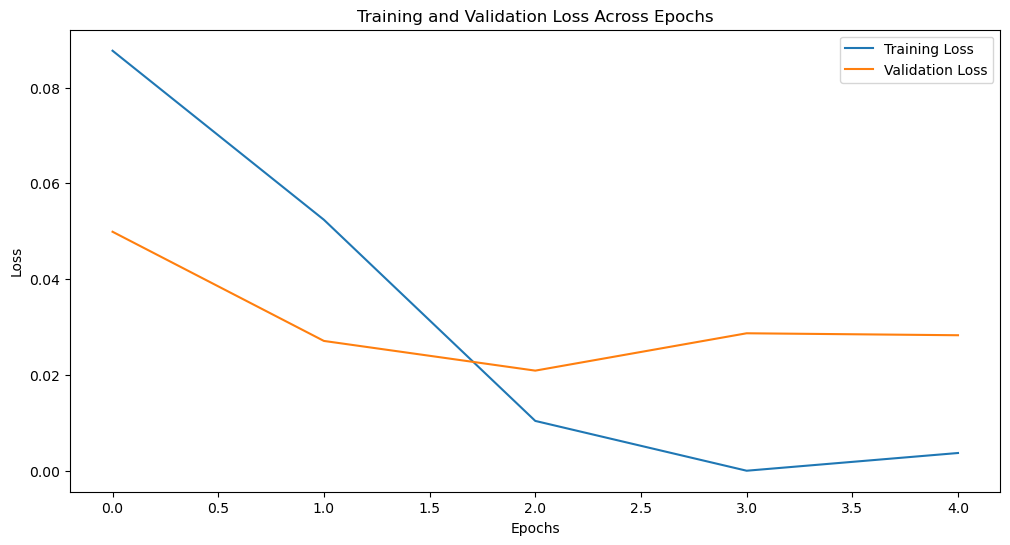

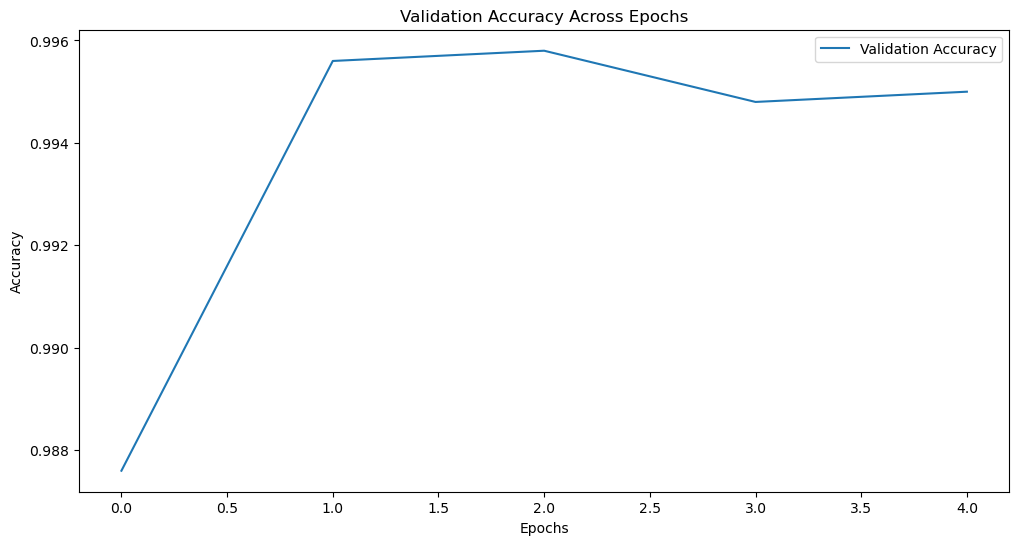

In [89]:
import matplotlib.pyplot as plt

# Assuming you have stored metrics like this during training
train_loss_values = [0.0877, 0.0524, 0.0104,0.000,0.0037]  # Replace with actual training loss values
val_loss_values = [0.0499, 0.0271, 0.0209,0.0287,0.02829]  # Replace with actual validation loss values
accuracy_values = [0.9876, 0.9956, 0.9958,0.9948,0.9950]  # Replace with actual validation accuracy values

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Across Epochs")
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy_values, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.legend()
plt.show()


In [77]:
# Evaluate the FinBERT model
trainer.evaluate()


{'eval_loss': 0.02089361473917961,
 'eval_accuracy': 0.9957973383142658,
 'eval_f1': 0.9957972420851323,
 'eval_precision': 0.9958127816274712,
 'eval_recall': 0.9957973383142658,
 'eval_runtime': 624.286,
 'eval_samples_per_second': 6.861,
 'eval_steps_per_second': 0.429,
 'epoch': 5.0}

In [87]:
# After training, load the 3rd epoch checkpoint manually
third_epoch_checkpoint = './results/checkpoint-3615'

# Load model from 3rd epoch checkpoint
finbert = BertForSequenceClassification.from_pretrained(third_epoch_checkpoint)

# Save the 3rd epoch's model
output_model_dir = './saved_finbert_model'
finbert.save_pretrained(output_model_dir)

# Save the tokenizer (important for reproducing tokenization)
tokenizer.save_pretrained(output_model_dir)

# Save training arguments (optional, to remember settings)
import json
training_args_dict = training_args.to_dict()
with open(f"{output_model_dir}/training_args.json", 'w') as f:
    json.dump(training_args_dict, f)

print(f'Model and tokenizer from 3rd epoch saved to {output_model_dir}')


Model and tokenizer from 3rd epoch saved to ./saved_finbert_model
